# とりあえずデータを観察する

In [1]:
import collections
import pathlib

# データ処理周り
import numpy as np
import pandas as pd
from IPython.core.display import display

# 可視化ライブラリ
import matplotlib.pyplot as plt
from matplotlib import cm # colormap
import seaborn as sns
%matplotlib inline

# pandasのwarningが邪魔なので
import warnings
warnings.filterwarnings('ignore')

# options
# pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')

In [2]:
data_path = pathlib.Path("../data")

## ファイル読み込み

train.csvは、184,903,891行(8GB)あるのでそのまま読み込みは厳しい。  
100,000行サンプリングされたデータと、testデータを読み込んでデータの概要を確認

In [3]:
train = pd.read_csv(data_path / "train_sample.csv")
train.shape

(100000, 8)

In [4]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


- ip: ip address of click.
- app: app id for marketing.
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)


*train only*
- attributed_time: appをダウンロードした場合はその時間が入っている
- is_attributed: the target that is to be predicted, indicating the app was downloaded

In [5]:
test = pd.read_csv(data_path / "test.csv")
test.shape

(18790469, 7)

In [6]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [7]:
submission = pd.read_csv(data_path / 'sample_submission.csv')[:100]
submission.shape

(100, 2)

In [8]:
submission.head()

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


## ip, app, device, os, channnel, click_timeの分布を基礎集計

### IP

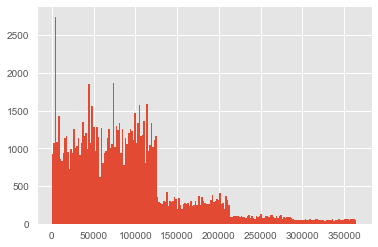

In [9]:
train.ip.hist(bins=200)

3段階に壁があるのが気になる。

In [10]:
apps = train.groupby('app').ip.count()
apps.shape

(161,)

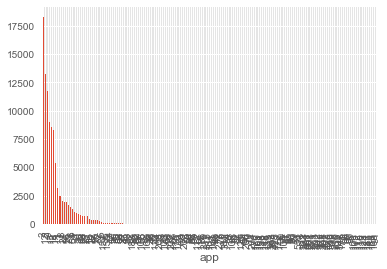

In [11]:
apps.sort_values(ascending=False).plot.bar()

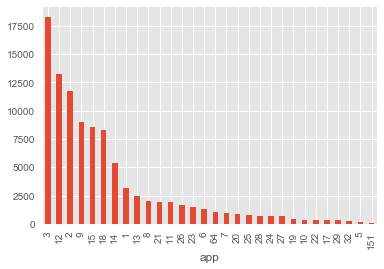

In [12]:
apps.sort_values(ascending=False)[:30].plot.bar()

- appはサンプルだと161種類
- データ数がそこそこあるのは30種類くらい

### device

In [13]:
devices = train.groupby('device').ip.count()
devices.shape

(100,)

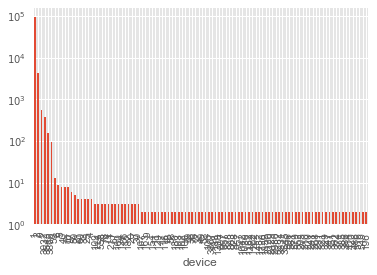

In [14]:
devices.sort_values(ascending=False).plot.bar(log=True)

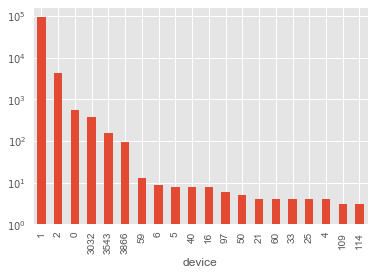

In [15]:
devices.sort_values(ascending=False)[:20].plot.bar(log=True)

- 多いのはトップ6種類くらい
- 0,1,2,3032, 3543, 3866

なんか飛んでるから４桁の方は不正なやつなんじゃないだろか(ただの予想)


### OS

In [16]:
oss = train.groupby('os').ip.count()
oss.shape

(130,)

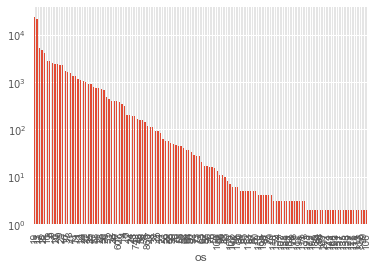

In [17]:
oss.sort_values(ascending=False).plot.bar(log=True)

これはそこそこばらついてそう。。。

### click_time

In [18]:
date = pd.to_datetime(train.click_time).dt.date
date.head()

0    2017-11-07
1    2017-11-07
2    2017-11-07
3    2017-11-07
4    2017-11-09
Name: click_time, dtype: object

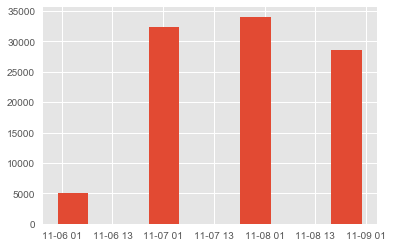

In [19]:
date.hist()

In [20]:
time_ = pd.to_datetime(train.click_time).dt.hour
time_.head()

0     9
1    13
2    18
3     4
4     9
Name: click_time, dtype: int64

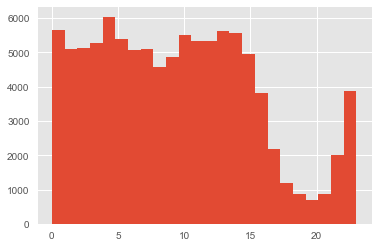

In [21]:
time_.hist(bins=24)

24~15時のアクセスが多い

## コンバージョン(DL)と各指標の関係

In [22]:
### データ加工

In [23]:
train.loc[:, "DL"] = (~train.attributed_time.isnull()).astype(int)
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,0


In [24]:
train.loc[:, "time_"] = pd.to_datetime(train.click_time).dt.hour
train.loc[:, "date"] = pd.to_datetime(train.click_time).dt.date
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,time_,date
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,0,9,2017-11-07
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,0,13,2017-11-07
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,0,18,2017-11-07
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,0,4,2017-11-07
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,0,9,2017-11-09


Appでコンバージョン率を確認

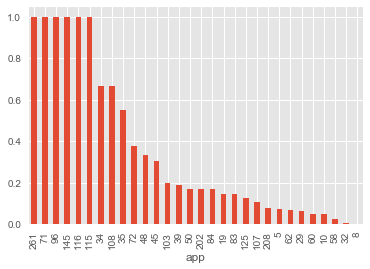

In [25]:
train.groupby('app').mean()['DL'].sort_values(ascending=False)[:30].plot.bar()

100%コンバージョン・・・？！　
カウントを考慮してみないとだめそう。。

In [26]:
g = train.groupby(['app', 'device', 'time_']).agg({'DL': 'mean', 'ip': 'count'}).reset_index()
g = g.rename(columns={'DL': 'DL_rate', 'ip': 'cnt'})
g.head()

,app,device,time_,DL_rate,cnt
0,1,1,0,0.0,224
1,1,1,1,0.0,135
2,1,1,2,0.0,175
3,1,1,3,0.0,138
4,1,1,4,0.0,166


In [27]:
g[(g['cnt'] > 10) & (g['DL_rate'] > 0)].sort_values(by='DL_rate', ascending=False)

,app,device,time_,DL_rate,cnt
791,19,0,23,0.250000,12
782,19,0,14,0.227273,22
778,19,0,10,0.212121,33
1233,29,1,1,0.187500,16
181,5,1,8,0.176471,17
773,19,0,5,0.166667,24
777,19,0,9,0.160000,25
1247,29,1,15,0.142857,14
177,5,1,4,0.142857,14
385,10,1,7,0.133333,15


## 人ごとに集計

ip, os, deviceでだいたい個人に近い単位になる気がする

In [28]:
g = train.groupby(['ip', 'os', 'device']).agg({'DL': 'sum', 'app': 'count'}).reset_index()
g = g.rename(columns={'DL': 'DLsum', 'app': 'cnt'})
g.head()

,ip,os,device,DLsum,cnt
0,9,13,1,0,1
1,10,13,1,0,1
2,10,19,1,0,1
3,10,22,1,0,1
4,19,16,1,0,1


In [29]:
users = g[['DLsum', 'cnt']]
users.head()

,DLsum,cnt
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


### 人ごとのクリックカウント

In [52]:
from sklearn.cluster import KMeans
k = 4

In [53]:
sorted_cnt = users.sort_values(by='cnt').reset_index()
cluster = KMeans(n_clusters=k).fit(sorted_cnt[['cnt']])

In [54]:
sorted_cnt.loc[:, 'cluster'] = cluster.labels_

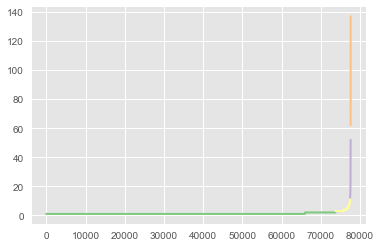

In [56]:
colors = cm.Accent.colors
for i in range(k):
    plt.plot(sorted_cnt[sorted_cnt.cluster == i]['cnt'], c=colors[i], linewidth=2)


In [57]:
sorted_cnt.loc[:, 'rate'] = sorted_cnt['DLsum']/sorted_cnt['cnt']
df = sorted_cnt[sorted_cnt.cluster == 0]
df.head()

,index,DLsum,cnt,cluster,rate
0,0,0,1,0,0.0
1,50814,0,1,0,0.0
2,50815,0,1,0,0.0
3,50816,0,1,0,0.0
4,50817,0,1,0,0.0


In [60]:
sorted_cnt.groupby('cluster').agg({'rate': ['mean', 'count'], 'cnt': ['mean','sum']})

rate                cnt       
             mean  count        mean    sum
cluster                                    
0        0.002854  73753    1.105555  81538
1        0.000302    144   19.430556   2798
2        0.001729      9  100.777778    907
3        0.000566   3710    3.977628  14757

In [61]:
sorted_cnt.rate.mean()

0.0027398866470025817

## ユーザごと・アプリごと

そろそろカーネルみよ・・・。

In [64]:
g = train.groupby(['ip', 'os', 'device', 'app']).agg({'DL': 'sum', 'channel': 'count'}).reset_index()
g = g.rename(columns={'DL': 'DLsum', 'channel': 'cnt'})
g.head()

,ip,os,device,app,DLsum,cnt
0,9,13,1,9,0,1
1,10,13,1,18,0,1
2,10,19,1,12,0,1
3,10,22,1,11,0,1
4,19,16,1,14,0,1
